In [ ]:
from math import sqrt
import os
import random

import argparse
import random
import math

from tqdm import tqdm
import numpy as np
from PIL import Image

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
from torch.nn import init
from torch.autograd import Function

import matplotlib.pyplot as plt
%matplotlib inline
#from dataset import MultiResolutionDataset
#from model import StyledGenerator, Discriminator
# train-> model, dataset

In [ ]:
#Generate txt
!pip install session_info
import session_info
session_info.show()
#!pip install -r requirements.txt

     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8045 sha256=54592495ad89fcf6a99285d1e577e73b64c232688c6f2f343b3255005a7abcfd
  Stored in directory: /root/.cache/pip/wheels/bd/ad/14/6a42359351a18337a8683854cfbba99dd782271f2d1767f87f
Successfully built session-info


In [ ]:
#model.py /

def init_linear(linear):
    """
    weight initialization, let the linear layers' weights following normal distribution.
    :param linear: torch linear layer
    """
    init.xavier_normal(linear.weight)
    linear.bias.data.zero_()

def init_conv(conv):
    """
    weight initialization, let the conv layers' weights following kaiming_normal distribution.
    set the bias equals to zero if it is noe None.
    :param linear: torch linear layer
    """
    init.kaiming_normal(conv.weight)
    if conv.bias is not None:
        conv.bias.data.zero_()

class EqualLR:
    """The class is used to apply equalized learning rate

    The calss has no object, but in Python3, it is a default that each class will inherit from object.

    Attributes:
        name: the name of the parameter used in the pytorch structure. Such as "weights" refer to some layes' weight.
    """
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        '''compute the model's weights'''
        weight = getattr(module, self.name + '_orig') #return the values from the parameters model.name+'_orig'
        fan_in = weight.data.size(1) * weight.data[0][0].numel() #fan_in -> kernel_size * kernel_size * in_features
        return weight * sqrt(2 / fan_in)

    @staticmethod #output function's statistic method. There is no need to instantiate a class
    def apply(module, name):
        '''apply the class EqualLR'''
        fn = EqualLR(name)
        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)
        return fn

        #build the EqualLR and get the weight we want.
        #delete elements from model._parameters, a dictionary of model.
        #add new parater in the model called (name + '_orig') which can be accessed as an attribute.
        #add hook:
        # same as calculate CAM image if you have tried.
        # since some value is gone instantly after the model finishing calculation, so we need hook function
        # registers a forward pre-hook on the module.
        #the hook will be called every time before forward() is invoked.
        #lastly, return the hook we made.

    def __call__(self, module, input):
        '''make the instances behave like functions and can be called like a function'''
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)#The setattr() function sets the value of the attribute of an object.

def equal_lr(module, name='weight'):
    '''apply the EqualLr'''
    EqualLR.apply(module, name)
    return module

class FusedUpsample(nn.Module):
    ''' Bilinear upsampling method fused with a de-convolution

    After emailing with the author, I got the FusedUpsample is just de-conv + bilinear upsample
    From the official implementation of styleGAN tensorflow, you can see the same structure:
      https://github.com/NVlabs/stylegan/blob/66813a32aac5045fcde72751522a0c0ba963f6f2/training/networks_stylegan.py#L174

    Attributes:
      ....
    '''
    def __init__(self, in_channel, out_channel, kernel_size, padding=0):
        super().__init__()
        weight = torch.randn(in_channel, out_channel, kernel_size, kernel_size)
        bias = torch.zeros(out_channel)
        fan_in = in_channel * kernel_size * kernel_size
        self.multiplier = sqrt(2 / fan_in)
        self.weight = nn.Parameter(weight)#A kind of Tensor that is to be considered a module parameter.
        self.bias = nn.Parameter(bias)#It's default require grade = True
        self.pad = padding

    def forward(self, input):
        weight = F.pad(self.weight * self.multiplier, [1, 1, 1, 1])
        weight = (
            weight[:, :, 1:, 1:]
            + weight[:, :, :-1, 1:]
            + weight[:, :, 1:, :-1]
            + weight[:, :, :-1, :-1]
        ) / 4
        out = F.conv_transpose2d(input, weight, self.bias, stride=2, padding=self.pad)
        return out

        #Bilinear upsampling:
        #pad = [1, 1, 1, 1] means the tensor is covered all 0
        #example:
        # [[2,2]  -> [[0,0,0,0],
        # ,[2,3]]    [0,2,2,0],
        #         [0,2,2,0],
        #         [0,0,0,0]]
        #calculate 4 parts weights and average them
        #[1:, 1:] -> reject values from the 1st row and col
        #[-1, :-1] -> reject values from the last row and col
        #[:-1, 1:] -> reject values from the last col and 1st row
        #[:-1, :-1] -> reject values from the last col and last row
        #applies a 2D transposed convolution operator over an input image composed of several input planes.

class FusedDownsample(nn.Module):
    ''' General same as above class'''
    def __init__(self, in_channel, out_channel, kernel_size, padding=0):
        super().__init__()
        weight = torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        bias = torch.zeros(out_channel)
        fan_in = in_channel * kernel_size * kernel_size
        self.multiplier = sqrt(2 / fan_in)
        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias)
        self.pad = padding

    def forward(self, input):
        weight = F.pad(self.weight * self.multiplier, [1, 1, 1, 1])
        weight = (
            weight[:, :, 1:, 1:]
            + weight[:, :, :-1, 1:]
            + weight[:, :, 1:, :-1]
            + weight[:, :, :-1, :-1]
        ) / 4
        out = F.conv2d(input, weight, self.bias, stride=2, padding=self.pad)#applies a 2D convolution over an input image composed of several input planes.
        return out

class PixelNorm(nn.Module):
    '''PixelNorm unify the pixels with the similar colour to be the same'''
    def __init__(self):
        super().__init__()
    def forward(self, input):
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

class BlurFunctionBackward(Function):
    ''' BlurFunctionBackward.backward will be called when you use backward on the value computed using gradient

    It will be not used during backward for the value computed using the result of the forward
    the implementation of backward pass of blur operation
    '''
    @staticmethod
    def forward(ctx, grad_output, kernel, kernel_flip):
        """
        define back backward function calculate gradient

        :param ctx: pytorch.ctx is a staticmethod used for saving parameters. It will be taken out when doing backpropagation.
        :param grad_output: input by 
        :param kernel: 
        :param kernel_flip: 
        """
        ctx.save_for_backward(kernel, kernel_flip)
        grad_input = F.conv2d(grad_output, kernel_flip, padding=1, groups=grad_output.shape[1]) #groups is for split the grad_output into several parts
        return grad_input

        #must be used when saving input or output tensors of the forward to be used later in the backward.
        #Anything else, i.e., non-tensors and tensors that are neither input nor output should be stored directly on ctx.

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, gradgrad_output):
        kernel, kernel_flip = ctx.saved_tensors #unpack saved_tensors and initialize all gradients w.r.t. inputs to None.
        grad_input = F.conv2d(gradgrad_output, kernel, padding=1, groups=gradgrad_output.shape[1])
        return grad_input, None, None

    #BlurFunctionBackward::backward is for 【double backprop】.
    #Improving generalization performance using double backpropagation - Yann LeCun
    #Some comments are directly copyed from the address below:
    #https://pytorch.org/docs/master/notes/extending.html


#For better understanding the BlurFunctionBackward and BlurFunction
#check the git issue address:
#https://github.com/rosinality/style-based-gan-pytorch/issues/89

class BlurFunction(Function):
    
    @staticmethod
    def forward(ctx, input, kernel, kernel_flip):
        ctx.save_for_backward(kernel, kernel_flip)

        output = F.conv2d(input, kernel, padding=1, groups=input.shape[1])

        return output

    @staticmethod
    def backward(ctx, grad_output):
        kernel, kernel_flip = ctx.saved_tensors

        grad_input = BlurFunctionBackward.apply(grad_output, kernel, kernel_flip)

        return grad_input, None, None

#Applies the function callable to each element in the tensor,
#replacing each element with the value returned by callable.
blur = BlurFunction.apply

#Making Convolutional Networks Shift-Invariant Again
#The blur kernel parameters are fixed
class Blur(nn.Module):
    def __init__(self, channel):
        super().__init__()

        weight = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32)
        weight = weight.view(1, 1, 3, 3)
        weight = weight / weight.sum()
        # switch the sequence
        # [Comment:]Not quite understand why using flip, found it on the styleGAN paper, needs to revise the paper
        weight_flip = torch.flip(weight, [2, 3])
        '''
        This is typically used to register a buffer
          that should not to be considered a model parameter.

        For example, BatchNorm's ``running_mean``
          is not a parameter, but is part of the persistent state.

        Buffers can be accessed as attributes using given names.
        '''
        self.register_buffer('weight', weight.repeat(channel, 1, 1, 1))
        self.register_buffer('weight_flip', weight_flip.repeat(channel, 1, 1, 1))

    def forward(self, input):
        return blur(input, self.weight, self.weight_flip)
        # return F.conv2d(input, self.weight, padding=1, groups=input.shape[1])

#blog: https://samaelchen.github.io/pytorch-pggan/
class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)


class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)


class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        padding,
        kernel_size2=None,
        padding2=None,
        downsample=False,
        fused=False,
    ):
        super().__init__()

        pad1 = padding
        pad2 = padding
        if padding2 is not None:
            pad2 = padding2

        kernel1 = kernel_size
        kernel2 = kernel_size
        if kernel_size2 is not None:
            kernel2 = kernel_size2

        self.conv1 = nn.Sequential(
            EqualConv2d(in_channel, out_channel, kernel1, padding=pad1),
            nn.LeakyReLU(0.2),
        )

        if downsample:
            if fused:
                self.conv2 = nn.Sequential(
                    Blur(out_channel),
                    FusedDownsample(out_channel, out_channel, kernel2, padding=pad2),
                    nn.LeakyReLU(0.2),
                )

            else:
                self.conv2 = nn.Sequential(
                    Blur(out_channel),
                    EqualConv2d(out_channel, out_channel, kernel2, padding=pad2),
                    nn.AvgPool2d(2),
                    nn.LeakyReLU(0.2),
                )

        else:
            self.conv2 = nn.Sequential(
                EqualConv2d(out_channel, out_channel, kernel2, padding=pad2),
                nn.LeakyReLU(0.2),
            )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        return out


class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, in_channel, style_dim):
        super().__init__()

        self.norm = nn.InstanceNorm2d(in_channel)
        self.style = EqualLinear(style_dim, in_channel * 2)

        self.style.linear.bias.data[:in_channel] = 1
        self.style.linear.bias.data[in_channel:] = 0

    def forward(self, input, style):
        style = self.style(style).unsqueeze(2).unsqueeze(3)
        #Splits a tensor into a specific number of chunks.
        gamma, beta = style.chunk(2, 1)

        out = self.norm(input)
        out = gamma * out + beta

        return out


class NoiseInjection(nn.Module):
    def __init__(self, channel):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))

    def forward(self, image, noise):
        return image + self.weight * noise

#Const 4*4*512
class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out


class StyledConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size=3,
        padding=1,
        style_dim=512,
        initial=False,
        upsample=False,
        fused=False,
    ):
        super().__init__()

        if initial:
            self.conv1 = ConstantInput(in_channel)

        else:
            if upsample:
                if fused:
                    self.conv1 = nn.Sequential(
                        FusedUpsample(
                            in_channel, out_channel, kernel_size, padding=padding
                        ),
                        Blur(out_channel),
                    )

                else:
                    self.conv1 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='nearest'),
                        EqualConv2d(
                            in_channel, out_channel, kernel_size, padding=padding
                        ),
                        Blur(out_channel),
                    )

            else:
                self.conv1 = EqualConv2d(
                    in_channel, out_channel, kernel_size, padding=padding
                )

        self.noise1 = equal_lr(NoiseInjection(out_channel))
        self.adain1 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu1 = nn.LeakyReLU(0.2)

        self.conv2 = EqualConv2d(out_channel, out_channel, kernel_size, padding=padding)
        self.noise2 = equal_lr(NoiseInjection(out_channel))
        self.adain2 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu2 = nn.LeakyReLU(0.2)

    def forward(self, input, style, noise):
        out = self.conv1(input)
        out = self.noise1(out, noise)
        out = self.lrelu1(out)
        out = self.adain1(out, style)

        out = self.conv2(out)
        out = self.noise2(out, noise)
        out = self.lrelu2(out)
        out = self.adain2(out, style)

        return out


class Generator(nn.Module):
    def __init__(self, code_dim, fused=True):
        super().__init__()

        self.progression = nn.ModuleList(
            [
                StyledConvBlock(512, 512, 3, 1, initial=True),  # 4
                StyledConvBlock(512, 512, 3, 1, upsample=True),  # 8
                StyledConvBlock(512, 512, 3, 1, upsample=True),  # 16
                StyledConvBlock(512, 512, 3, 1, upsample=True),  # 32
                StyledConvBlock(512, 256, 3, 1, upsample=True),  # 64
                StyledConvBlock(256, 128, 3, 1, upsample=True, fused=fused),  # 128
                StyledConvBlock(128, 64, 3, 1, upsample=True, fused=fused),  # 256
                StyledConvBlock(64, 32, 3, 1, upsample=True, fused=fused),  # 512
                StyledConvBlock(32, 16, 3, 1, upsample=True, fused=fused),  # 1024
            ]
        )

        self.to_rgb = nn.ModuleList(
            [
                EqualConv2d(512, 3, 1),
                EqualConv2d(512, 3, 1),
                EqualConv2d(512, 3, 1),
                EqualConv2d(512, 3, 1),
                EqualConv2d(256, 3, 1),
                EqualConv2d(128, 3, 1),
                EqualConv2d(64, 3, 1),
                EqualConv2d(32, 3, 1),
                EqualConv2d(16, 3, 1),
            ]
        )

        # self.blur = Blur()
    '''
    Author comment:
      To do mixing regularization,
        you should choice some layers (index),
        and use secondary latent codes after that layer.
      inject_index and crossover is for implement this.
    '''
    def forward(self, style, noise, step=0, alpha=-1, mixing_range=(-1, -1)):
        #should be torch.randn(batch, 1, 4, 4)
        out = noise[0]

        #inject_index = [9]
        if len(style) < 2:
            inject_index = [len(self.progression) + 1]

        else:
            #list is depend on the step(resolution)
            #from list sample len(style)-1 values
            inject_index = sorted(random.sample(list(range(step)), len(style) - 1))

        crossover = 0

        #(conv,to_rgb) = (StyledConvBlock,EqualConv2d)
        for i, (conv, to_rgb) in enumerate(zip(self.progression, self.to_rgb)):
            if mixing_range == (-1, -1):
                #crossover > number of values in inject_index
                #and
                #i > inject_index[crossover]
                if crossover < len(inject_index) and i > inject_index[crossover]:
                    crossover = min(crossover + 1, len(style))
                # style_step is the selected style
                style_step = style[crossover]

            else:
                if mixing_range[0] <= i <= mixing_range[1]:
                    style_step = style[1]

                else:
                    style_step = style[0]

            if i > 0 and step > 0:
                out_prev = out

            #conv.forward(input,style,noise)
            out = conv(out, style_step, noise[i])


            #if i==step cut the iternation
            if i == step:
                out = to_rgb(out)

                if i > 0 and 0 <= alpha < 1:
                    #skip the current rgb layer
                    skip_rgb = self.to_rgb[i - 1](out_prev)
                    #nearest up sampling
                    skip_rgb = F.interpolate(skip_rgb, scale_factor=2, mode='nearest')
                    out = (1 - alpha) * skip_rgb + alpha * out

                break

        return out


class StyledGenerator(nn.Module):
    def __init__(self, code_dim=512, n_mlp=8):
        super().__init__()

        self.generator = Generator(code_dim)

        layers = [PixelNorm()]
        for i in range(n_mlp):
            layers.append(EqualLinear(code_dim, code_dim))
            layers.append(nn.LeakyReLU(0.2))
        #mapping network f
        self.style = nn.Sequential(*layers)

    def forward(
        self,
        input,
        noise=None,
        step=0,
        alpha=-1,
        mean_style=None,
        style_weight=0,
        mixing_range=(-1, -1),
    ):
        styles = []
        #check input type
        #since it needs input to be a list or tuple, because of Mixing operation
        #if not mixing, it will get  a tensor
        # input should becomes -> [latent_code1, latent_code2] or [latent_code1]
        #latent_code1 with a shape of [batch_size,laten_code_size]
        if type(input) not in (list, tuple):
            input = [input]

        for i in input:
            #let the latent code go into the mapping network f
            styles.append(self.style(i))
        #input[0] = latent_code1, shape[0]-> batch_size
        batch = input[0].shape[0]

        #Add noise, in the original no noise is added
        if noise is None:
            noise = []
            #number of noise = value of step
            for i in range(step + 1):
                size = 4 * 2 ** i #same as resolution
                noise.append(torch.randn(batch, 1, size, size, device=input[0].device))

        if mean_style is not None:
            styles_norm = []
            #normalize the style
            for style in styles:
                styles_norm.append(mean_style + style_weight * (style - mean_style))

            styles = styles_norm

        return self.generator(styles, noise, step, alpha, mixing_range=mixing_range)
    # used for testin the generator after finish training
    def mean_style(self, input):
        style = self.style(input).mean(0, keepdim=True)

        return style


class Discriminator(nn.Module):
    def __init__(self, fused=True, from_rgb_activate=False):
        super().__init__()

        self.progression = nn.ModuleList(
            [
                ConvBlock(16, 32, 3, 1, downsample=True, fused=fused),  # 512
                ConvBlock(32, 64, 3, 1, downsample=True, fused=fused),  # 256
                ConvBlock(64, 128, 3, 1, downsample=True, fused=fused),  # 128
                ConvBlock(128, 256, 3, 1, downsample=True, fused=fused),  # 64
                ConvBlock(256, 512, 3, 1, downsample=True),  # 32
                ConvBlock(512, 512, 3, 1, downsample=True),  # 16
                ConvBlock(512, 512, 3, 1, downsample=True),  # 8
                ConvBlock(512, 512, 3, 1, downsample=True),  # 4
                ConvBlock(513, 512, 3, 1, 4, 0),
            ]
        )

        def make_from_rgb(out_channel):
            if from_rgb_activate:
                return nn.Sequential(EqualConv2d(3, out_channel, 1), nn.LeakyReLU(0.2))

            else:
                return EqualConv2d(3, out_channel, 1)

        self.from_rgb = nn.ModuleList(
            [
                make_from_rgb(16),
                make_from_rgb(32),
                make_from_rgb(64),
                make_from_rgb(128),
                make_from_rgb(256),
                make_from_rgb(512),
                make_from_rgb(512),
                make_from_rgb(512),
                make_from_rgb(512),
            ]
        )

        # self.blur = Blur()

        self.n_layer = len(self.progression)

        self.linear = EqualLinear(512, 1)

    def forward(self, input, step=0, alpha=-1):
        for i in range(step, -1, -1):
            index = self.n_layer - i - 1

            if i == step:
                out = self.from_rgb[index](input)

            if i == 0:
                out_std = torch.sqrt(out.var(0, unbiased=False) + 1e-8)
                mean_std = out_std.mean()
                mean_std = mean_std.expand(out.size(0), 1, 4, 4)
                out = torch.cat([out, mean_std], 1)

            out = self.progression[index](out)

            if i > 0:
                if i == step and 0 <= alpha < 1:
                    skip_rgb = F.avg_pool2d(input, 2)
                    skip_rgb = self.from_rgb[index + 1](skip_rgb)

                    out = (1 - alpha) * skip_rgb + alpha * out

        out = out.squeeze(2).squeeze(2)
        # print(input.size(), out.size(), step)
        out = self.linear(out)

        return out

In [ ]:
#train
def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(1 - decay, par2[k].data)

def sample_data(dataset, batch_size, image_size=4):
    dataset.resolution = image_size
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=1, drop_last=True)

    return loader

def adjust_lr(optimizer, lr):
    for group in optimizer.param_groups:
        mult = group.get('mult', 1)
        group['lr'] = lr * mult

def train(args, dataset, generator, discriminator):
    step = int(math.log2(args.init_size)) - 2
    resolution = 4 * 2 ** step
    loader = sample_data(
        dataset, args.batch.get(resolution, args.batch_default), resolution
    )
    data_loader = iter(loader)

    adjust_lr(g_optimizer, args.lr.get(resolution, 0.001))
    adjust_lr(d_optimizer, args.lr.get(resolution, 0.001))

    pbar = tqdm(range(70_000))

    requires_grad(generator, False)
    requires_grad(discriminator, True)

    disc_loss_val = 0
    gen_loss_val = 0
    grad_loss_val = 0

    alpha = 0
    used_sample = 0

    max_step = int(math.log2(args.max_size)) - 2
    final_progress = False

    for i in pbar:
        discriminator.zero_grad()

        alpha = min(1, 1 / args.phase * (used_sample + 1))

        if (resolution == args.init_size and args.ckpt is None) or final_progress:
            alpha = 1

        if used_sample > args.phase * 2:
            used_sample = 0
            step += 1

            if step > max_step:
                step = max_step
                final_progress = True
                ckpt_step = step + 1

            else:
                alpha = 0
                ckpt_step = step

            resolution = 4 * 2 ** step

            loader = sample_data(
                dataset, args.batch.get(resolution, args.batch_default), resolution
            )
            data_loader = iter(loader)

            torch.save(
                {
                    'generator': generator.module.state_dict(),
                    'discriminator': discriminator.module.state_dict(),
                    'g_optimizer': g_optimizer.state_dict(),
                    'd_optimizer': d_optimizer.state_dict(),
                    'g_running': g_running.state_dict(),
                },
                f'checkpoint/train_step-{ckpt_step}.model',
            )
            #if ckpt_step == 5:
              #!cp "/content/checkpoint/train_step-5.model" "/content/drive/MyDrive/Pre_Trained_Model"
            adjust_lr(g_optimizer, args.lr.get(resolution, 0.001))
            adjust_lr(d_optimizer, args.lr.get(resolution, 0.001))

        try:
            real_image = next(data_loader)

        except (OSError, StopIteration):
            data_loader = iter(loader)
            real_image = next(data_loader)

        used_sample += real_image.shape[0]

        b_size = real_image.size(0)
        real_image = real_image.cuda()

        if args.loss == 'wgan-gp':
            real_predict = discriminator(real_image, step=step, alpha=alpha)
            real_predict = real_predict.mean() - 0.001 * (real_predict ** 2).mean()
            (-real_predict).backward()

        elif args.loss == 'r1':
            real_image.requires_grad = True
            real_scores = discriminator(real_image, step=step, alpha=alpha)
            real_predict = F.softplus(-real_scores).mean()
            real_predict.backward(retain_graph=True)

            grad_real = grad(
                outputs=real_scores.sum(), inputs=real_image, create_graph=True
            )[0]
            grad_penalty = (
                grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
            ).mean()
            grad_penalty = 10 / 2 * grad_penalty
            grad_penalty.backward()
            if i%10 == 0:
                grad_loss_val = grad_penalty.item()

        if args.mixing and random.random() < 0.9:
            #create a rand tensor with the shape [4,batch_size,laten_code_size]
            #Then, split into 4 part each has [1,batch_size,laten_vector_size]
            gen_in11, gen_in12, gen_in21, gen_in22 = torch.randn(
                4, b_size, code_size, device='cuda'
            ).chunk(4, 0)
            # make a list, squeeze method delete the first dimension
            # gen_in11.shape = [batch_size,laten_code_size]
            gen_in1 = [gen_in11.squeeze(0), gen_in12.squeeze(0)]
            gen_in2 = [gen_in21.squeeze(0), gen_in22.squeeze(0)]

        else:
            gen_in1, gen_in2 = torch.randn(2, b_size, code_size, device='cuda').chunk(
                2, 0
            )
            gen_in1 = gen_in1.squeeze(0)
            gen_in2 = gen_in2.squeeze(0)

        fake_image = generator(gen_in1, step=step, alpha=alpha)
        fake_predict = discriminator(fake_image, step=step, alpha=alpha)

        if args.loss == 'wgan-gp':
            fake_predict = fake_predict.mean()
            fake_predict.backward()

            eps = torch.rand(b_size, 1, 1, 1).cuda()
            x_hat = eps * real_image.data + (1 - eps) * fake_image.data
            x_hat.requires_grad = True
            hat_predict = discriminator(x_hat, step=step, alpha=alpha)
            grad_x_hat = grad(
                outputs=hat_predict.sum(), inputs=x_hat, create_graph=True
            )[0]
            grad_penalty = (
                (grad_x_hat.view(grad_x_hat.size(0), -1).norm(2, dim=1) - 1) ** 2
            ).mean()
            grad_penalty = 10 * grad_penalty
            grad_penalty.backward()
            if i%10 == 0:
                grad_loss_val = grad_penalty.item()
                disc_loss_val = (-real_predict + fake_predict).item()

        elif args.loss == 'r1':
            fake_predict = F.softplus(fake_predict).mean()
            fake_predict.backward()
            if i%10 == 0:
                disc_loss_val = (real_predict + fake_predict).item()

        d_optimizer.step()

        if (i + 1) % n_critic == 0:
            generator.zero_grad()

            requires_grad(generator, True)
            requires_grad(discriminator, False)

            fake_image = generator(gen_in2, step=step, alpha=alpha)

            predict = discriminator(fake_image, step=step, alpha=alpha)

            if args.loss == 'wgan-gp':
                loss = -predict.mean()

            elif args.loss == 'r1':
                loss = F.softplus(-predict).mean()

            if i%10 == 0:
                gen_loss_val = loss.item()

            loss.backward()
            g_optimizer.step()
            accumulate(g_running, generator.module)

            requires_grad(generator, False)
            requires_grad(discriminator, True)

        if (i + 1) % 100 == 0:
            images = []

            gen_i, gen_j = args.gen_sample.get(resolution, (10, 5))

            with torch.no_grad():
                for _ in range(gen_i):
                    images.append(
                        g_running(
                            torch.randn(gen_j, code_size).cuda(), step=step, alpha=alpha
                        ).data.cpu()
                    )

            utils.save_image(
                torch.cat(images, 0),
                f'sample/{str(i + 1).zfill(6)}.png',
                nrow=gen_i,
                normalize=True,
                range=(-1, 1),
            )
        if (i + 1) % 10000 == 0:
            torch.save(
                g_running.state_dict(), f'checkpoint/{str(i + 1).zfill(6)}.model'
            )

        state_msg = (
            f'Size: {4 * 2 ** step}; G: {gen_loss_val:.3f}; D: {disc_loss_val:.3f};'
            f' Grad: {grad_loss_val:.3f}; Alpha: {alpha:.5f}'
        )

        pbar.set_description(state_msg)

# Main operation and dataset

In [ ]:
#dataset.py
class MultiResolutionDataset(Dataset):
    def __init__(self, path, transform, resolution=8):
        self.env = lmdb.open(
            path,
            max_readers=32,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )

        if not self.env:
            raise IOError('Cannot open lmdb dataset', path)

        with self.env.begin(write=False) as txn:
            self.length = int(txn.get('length'.encode('utf-8')).decode('utf-8'))

        self.resolution = resolution
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        with self.env.begin(write=False) as txn:
            key = f'{self.resolution}-{str(index).zfill(5)}'.encode('utf-8')
            img_bytes = txn.get(key)

        buffer = BytesIO(img_bytes)
        img = Image.open(buffer)
        img = self.transform(img)

        return img

In [ ]:
from IPython.display import clear_output
import argparse
from io import BytesIO
import multiprocessing
from functools import partial
from PIL import Image
import lmdb
from tqdm import tqdm
from torchvision import datasets
from torchvision.transforms import functional as trans_fn

!unzip /content/drive/MyDrive/Data_Set/keras_png_slices_COMP3710.zip -d /content/data
clear_output()

def resize_and_convert(img, size, quality=100):
    img = trans_fn.resize(img, size, Image.LANCZOS) #Lanczos Re-sample
    img = trans_fn.center_crop(img, size) #crop
    buffer = BytesIO() # create a data type named BytesIO
    img.save(buffer, format='jpeg', quality=quality)
    #getvalue used to get the content just be wrote into the disk
    val = buffer.getvalue()

    return val


def resize_multiple(img, sizes=(8, 16, 32, 64, 128, 256, 512, 1024), quality=100):
    imgs = []

    for size in sizes:
        imgs.append(resize_and_convert(img, size, quality))

    return imgs


def resize_worker(img_file, sizes):
    i, file = img_file
    img = Image.open(file)
    img = img.convert('RGB')
    out = resize_multiple(img, sizes=sizes)

    return i, out


def prepare(transaction, dataset, n_worker, sizes=(8, 16, 32, 64, 128, 256, 512, 1024)):
    #function.partial
    resize_fn = partial(resize_worker, sizes=sizes)

    files = sorted(dataset.imgs, key=lambda x: x[0])
    files = [(i, file) for i, (file, label) in enumerate(files)]
    total = 0

    with multiprocessing.Pool(n_worker) as pool:
        for i, imgs in tqdm(pool.imap_unordered(resize_fn, files)):
            for size, img in zip(sizes, imgs):
                key = f'{size}-{str(i).zfill(5)}'.encode('utf-8')
                transaction.put(key, img)

            total += 1

        transaction.put('length'.encode('utf-8'), str(total).encode('utf-8'))


parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.out = '/content/IM'
args.n_worker = 2
args.path = '/content/data/sample'

imgset = datasets.ImageFolder(args.path)

with lmdb.open(args.out, map_size=1024 ** 4, readahead=False) as env:
    with env.begin(write=True) as txn:
        prepare(txn, imgset, args.n_worker, sizes=(8, 16, 32, 64, 128, 256, 512))

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
    ]
)
dataset = MultiResolutionDataset(args.out, transform = transform, resolution=8)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
11328it [02:17, 82.33it/s]


NameError: ignored

In [ ]:
code_size = 512
batch_size = 4 #8
n_critic = 1

try:
  os.mkdir('sample')
  os.mkdir('checkpoint')
except:
  print('file already exist？')
parser = argparse.ArgumentParser(description='Progressive Growing of GANs')

parser.add_argument(
    '--phase',
    type=int,
    default=600_000,
    help='number of samples used for each training phases',
)
parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
parser.add_argument('--sched', default=False, action='store_true', help='use lr scheduling')
parser.add_argument('--init_size', default=256, type=int, help='initial image size') #256
parser.add_argument('--max_size', default=256, type=int, help='max image size')
parser.add_argument('--ckpt', default=None, type=str, help='load from previous checkpoints')
parser.add_argument(
    '--no_from_rgb_activate',
    action='store_true',
    help='use activate in from_rgb (original implementation)',
)
parser.add_argument(
    '--mixing', action='store_true', help='use mixing regularization'
)
parser.add_argument(
    '--loss',
    type=str,
    default='wgan-gp',
    choices=['wgan-gp', 'r1'],
    help='class of gan loss',
)

args = parser.parse_args(args=[])
# training with multiple gpus
generator = nn.DataParallel(StyledGenerator(code_size)).cuda()
discriminator = nn.DataParallel(
    Discriminator(from_rgb_activate=not args.no_from_rgb_activate)
).cuda()
g_running = StyledGenerator(code_size).cuda()
g_running.train(False)

g_optimizer = optim.Adam(
    generator.module.generator.parameters(), lr=args.lr, betas=(0.0, 0.99)
)
g_optimizer.add_param_group(
    {
        'params': generator.module.style.parameters(),
        'lr': args.lr * 0.01,
        'mult': 0.01,
    }
)
d_optimizer = optim.Adam(discriminator.parameters(), lr=args.lr, betas=(0.0, 0.99))

accumulate(g_running, generator.module, 0)
args.ckpt = '/content/drive/MyDrive/Pre_Trained_Model/StyleGAN/andy_version3.model'
if args.ckpt is not None:
    print('load model')
    ckpt = torch.load(args.ckpt)

    generator.module.load_state_dict(ckpt['generator'])
    discriminator.module.load_state_dict(ckpt['discriminator'])
    g_running.load_state_dict(ckpt['g_running'])
    g_optimizer.load_state_dict(ckpt['g_optimizer'])
    d_optimizer.load_state_dict(ckpt['d_optimizer'])

if args.sched:
    args.lr = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}
    args.batch = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32, 128: 32, 256: 32}

else:
    args.lr = {}
    args.batch = {}

args.gen_sample = {512: (8, 4), 1024: (4, 2)}

args.batch_default = batch_size

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  # This is added back by InteractiveShellApp.init_path()


load model


In [ ]:
train(args, dataset, generator, discriminator)

Size: 256; G: -11.287; D: 0.638; Grad: 0.748; Alpha: 1.00000:   0%|          | 99/70000 [01:37<18:36:41,  1.04it/s]/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
Size: 256; G: 9.773; D: -7.431; Grad: 1.227; Alpha: 1.00000:  49%|████▊     | 34016/70000 [9:35:33<10:08:51,  1.02s/it]


KeyboardInterrupt: ignored

In [ ]:
torch.save(
  {
      'generator': generator.module.state_dict(),
      'discriminator': discriminator.module.state_dict(),
      'g_optimizer': g_optimizer.state_dict(),
      'd_optimizer': d_optimizer.state_dict(),
      'g_running': g_running.state_dict(),
  },
  f'checkpoint/andy_version91.model',
)
!cp "/content/checkpoint/andy_version91.model" "/content/drive/MyDrive/Pre_Trained_Model/StyleGAN"

# Generation Test

In [ ]:
@torch.no_grad()
def get_mean_style(generator, device):
    # generate 1024 codes ten times and average them
    mean_style = None

    for i in range(10):
        style = generator.mean_style(torch.randn(1024, 512).to(device))

        if mean_style is None:
            mean_style = style

        else:
            mean_style += style

    mean_style /= 10
    return mean_style

@torch.no_grad()
def sample(generator, step, mean_style, n_sample, device):
    image = generator(
        torch.randn(n_sample, 512).to(device),
        step=step,
        alpha=1,
        mean_style=mean_style,
        style_weight=0.7,
    )
    
    return image

@torch.no_grad()
def style_mixing(generator, step, mean_style, n_source, n_target, device):
    source_code = torch.randn(n_source, 512).to(device)
    target_code = torch.randn(n_target, 512).to(device)
    
    shape = 4 * 2 ** step
    alpha = 1

    images = [torch.zeros(1, 3, shape, shape).to(device) * -1]
    images_data = {}
    images_data[0] = (0,0)

    source_image = generator(
        source_code, step=step, alpha=alpha, mean_style=mean_style, style_weight=0.7
    )
    target_image = generator(
        target_code, step=step, alpha=alpha, mean_style=mean_style, style_weight=0.7
    )
    
    images.append(source_image)
    for i in range(n_source):
      images_data[i+1] = (torch.mean(source_image[i]),torch.std(source_image[i]))
    #print('end for source_image')
    images_data_length = len(images_data)
    #images_data.append()
    for i in range(n_target):
        image = generator(
            [target_code[i].unsqueeze(0).repeat(n_source, 1), source_code],
            step=step,
            alpha=alpha,
            mean_style=mean_style,
            style_weight=0.7,
            mixing_range=(0, 1),
        )

        images_data[images_data_length] = (torch.mean(target_image[i].unsqueeze(0)),torch.std(target_image[i].unsqueeze(0)))
        for j in range(n_source):
          images_data[images_data_length+1+j] = (torch.mean(image[j]),torch.std(image[j]))
        images_data_length = len(images_data)

        images.append(target_image[i].unsqueeze(0))
        images.append(image)

    # joint tensor
    images = torch.cat(images, 0)
    
    return images,images_data

NameError: ignored

In [ ]:
device = 'cuda'
test_path = '/content/drive/MyDrive/Pre_Trained_Model/StyleGAN/andy_version4.model'
generator = StyledGenerator(512).cuda()
generator.load_state_dict(torch.load(test_path)['g_running'])
generator.eval()

mean_style = get_mean_style(generator, device)
step = int(math.log(256, 2)) - 2
img = sample(generator, step, mean_style, 3 * 5, device)
utils.save_image(img, 'sample.png', nrow=5, normalize=True, range=(-1, 1))

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


#Style Analysis

In [ ]:
device = 'cuda'
test_path = '/content/drive/MyDrive/Pre_Trained_Model/StyleGAN/andy_version4.model'
generator = StyledGenerator(512).cuda()
generator.load_state_dict(torch.load(test_path)['g_running'])
generator.eval()

In [ ]:
step = int(math.log(256, 2)) - 2
img,images_data = style_mixing(generator, step, mean_style=None, n_source=3, n_target=3, device=device)
utils.save_image(img, 'sample.png', nrow=4, normalize=True, range=(-1, 1))

end for source_image


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


In [ ]:
print(images_data)

{0: (0, 0), 1: (tensor(-0.7271, device='cuda:0'), tensor(0.3776, device='cuda:0')), 2: (tensor(-0.7557, device='cuda:0'), tensor(0.3072, device='cuda:0')), 3: (tensor(-0.7431, device='cuda:0'), tensor(0.3635, device='cuda:0')), 4: (tensor(-0.7412, device='cuda:0'), tensor(0.3718, device='cuda:0')), 5: (tensor(-0.7412, device='cuda:0'), tensor(0.3654, device='cuda:0')), 6: (tensor(-0.7412, device='cuda:0'), tensor(0.3549, device='cuda:0')), 7: (tensor(-0.7412, device='cuda:0'), tensor(0.3697, device='cuda:0')), 8: (tensor(-0.7404, device='cuda:0'), tensor(0.3547, device='cuda:0')), 9: (tensor(-0.7404, device='cuda:0'), tensor(0.3483, device='cuda:0')), 10: (tensor(-0.7404, device='cuda:0'), tensor(0.3344, device='cuda:0')), 11: (tensor(-0.7404, device='cuda:0'), tensor(0.3548, device='cuda:0')), 12: (tensor(-0.7578, device='cuda:0'), tensor(0.3500, device='cuda:0')), 13: (tensor(-0.7578, device='cuda:0'), tensor(0.3485, device='cuda:0')), 14: (tensor(-0.7578, device='cuda:0'), tensor(0.

# Random Noise

In [ ]:
device = 'cuda'
test_path = '/content/drive/MyDrive/Pre_Trained_Model/StyleGAN/andy_version4.model'
generator = StyledGenerator(512).cuda()
generator.load_state_dict(torch.load(test_path)['g_running'])
generator.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


In [ ]:
#different noise
random_seed = 45654897
n_sample = 1
torch.manual_seed(random_seed)
latent_code = torch.randn(n_sample, 512).to(device)
step = int(math.log(256, 2)) - 2

for j in range(3):
  random_seed = j*512
  torch.manual_seed(random_seed)

  img = generator(
    latent_code,
    noise= None,
    step=step,
    alpha=1,
    mean_style=None,
    style_weight=0,
    mixing_range=(-1, -1),
  )
  utils.save_image(img, 'sample{index}.png'.format(index=j), nrow=1, normalize=True, range=(-1, 1))

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


In [ ]:
# zero noise and full noise
random_seed = 19971014
n_sample = 1
torch.manual_seed(random_seed)
latent_code = torch.randn(n_sample, 512).to(device)
step = int(math.log(256, 2)) - 2

noise = []
#number of noise = value of step
for i in range(step + 1):
  size = 4 * 2 ** i #same as resolution
  noise.append(torch.zeros(1, 1, size, size).to(device))
  #noise.append(torch.randn(batch, 1, size, size, device=input[0].device))

img_noise_zero = generator(
  latent_code,
  noise= noise,
  step=step,
  alpha=1,
  mean_style=None,
  style_weight=0,
  mixing_range=(-1, -1),
)
utils.save_image(img_noise_zero, 'sample_noise_zero.png', nrow=1, normalize=True, range=(-1, 1))

img_noise = generator(
  latent_code,
  noise= None,
  step=step,
  alpha=1,
  mean_style=None,
  style_weight=0,
  mixing_range=(-1, -1),
)
utils.save_image(img_noise, 'sample_noise.png', nrow=1, normalize=True, range=(-1, 1))


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


In [ ]:
# noise with resolution 8-16 and noise with resolution >16
random_seed = 19971014
n_sample = 1
torch.manual_seed(random_seed)
latent_code = torch.randn(n_sample, 512).to(device)
step = int(math.log(256, 2)) - 2

#8-16
noise_coarse_layers = []
#number of noise = value of step
for i in range(step + 1):
  size = 4 * 2 ** i #same as resolution
  if i<2:
    noise_coarse_layers.append(torch.randn(1, 1, size, size).to(device))
  else:
    noise_coarse_layers.append(torch.zeros(1, 1, size, size).to(device))

#>16
noise_fine_layers = []
#number of noise = value of step
for i in range(step + 1):
  size = 4 * 2 ** i #same as resolution
  if i>=2:
    noise_fine_layers.append(torch.randn(1, 1, size, size).to(device))
  else:
    noise_fine_layers.append(torch.zeros(1, 1, size, size).to(device))

img_coarse_layers = generator(
  latent_code,
  noise= noise_coarse_layers,
  step=step,
  alpha=1,
  mean_style=None,
  style_weight=0,
  mixing_range=(-1, -1),
)
utils.save_image(img_coarse_layers, 'sample_coarse_layers.png', nrow=1, normalize=True, range=(-1, 1))

img_fine_layers = generator(
  latent_code,
  noise= noise_fine_layers,
  step=step,
  alpha=1,
  mean_style=None,
  style_weight=0,
  mixing_range=(-1, -1),
)
utils.save_image(img_fine_layers, 'sample_fine_layers.png', nrow=1, normalize=True, range=(-1, 1))

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


# Gram matrix

In [ ]:
def gram_matrix(input):
  '''
  input.shape = [C, H, W]
  '''
  C, H, W = input.size()

  features = input.view(C, H * W)  # resise F_XL into \hat F_XL

  G = torch.mm(features, features.t())  # compute the gram product

  # we 'normalize' the values of the gram matrix
  # by dividing by the number of element in each feature maps.
  return G.div(C * H * W)

#What I learned from the code

def StyleLoss(inputA,inputB):
  G_A = gram_matrix(inputA).detach()
  G_B = gram_matrix(inputB).detach()
  return F.mse_loss(G_A, G_B)

In [ ]:
device = 'cuda'
test_path = '/content/drive/MyDrive/Pre_Trained_Model/StyleGAN/andy_version4.model'
generator = StyledGenerator(512).cuda()
generator.load_state_dict(torch.load(test_path)['g_running'])
generator.eval()

In [ ]:
step = int(math.log(256, 2)) - 2
img,_ = style_mixing(generator, step, mean_style=None, n_source=1, n_target=2, device=device)
utils.save_image(img, 'sample.png', nrow=2, normalize=True, range=(-1, 1))

end for source_image


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


In [ ]:
T = 0
for i in range(1000):
  step = int(math.log(256, 2)) - 2
  img,_ = style_mixing(generator, step, mean_style=None, n_source=1, n_target=2, device=device)
  utils.save_image(img, 'sample.png', nrow=2, normalize=True, range=(-1, 1))

  MSE_21 = StyleLoss(img[2],img[1]).item()
  MSE_31 = StyleLoss(img[3],img[1]).item()
  MSE_23 = StyleLoss(img[2],img[3]).item()
  #print(MSE_21)
  #print(MSE_31)
  #print(MSE_23)
  J = MSE_31>MSE_23
  if J == True:
    T = T + 1
print(T/1000)

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


0.876


# U map

In [ ]:
!pip install umap-learn
import umap.umap_ as umap

In [ ]:
device = 'cuda'
test_path = '/content/drive/MyDrive/Pre_Trained_Model/StyleGAN/andy_version4.model'
generator = StyledGenerator(512).cuda()
generator.load_state_dict(torch.load(test_path)['g_running'])
generator.eval()
mapNet = generator.style

In [ ]:
#different noise
power = 6
random_seed = 512558
n_sample = 1
outputs  = []
step = int(math.log(256, 2)) - 2
for i in range(10):
  torch.manual_seed(random_seed)
  z_i = torch.randn(n_sample, 512)
  outputs.append(z_i)
latent_code_z = torch.cat(outputs, dim=0).to(device)
for i in range(10):
  latent_code_z[i][98] = latent_code_z[i][98]+i**power
  t = latent_code_z[i].unsqueeze(0)
  img = generator(
      t,
      noise= None,
      step=step,
      alpha=1,
      mean_style=None,
      style_weight=0,
      mixing_range=(-1, -1),
      )
  utils.save_image(img, 'sample{index}.png'.format(index=i), nrow=1, normalize=True, range=(-1, 1))


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


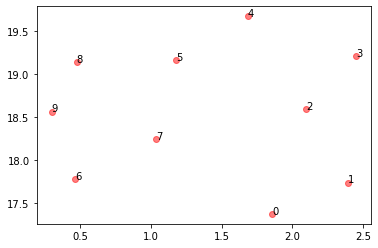

In [ ]:
latent_code_w = mapNet(latent_code_z)
# take latent_code_w out from gpu to cpu and convert to numpy
latent_code_w = latent_code_w.cpu().detach().numpy()
reducer = umap.UMAP(random_state = 4565489)  # Create our reducer
embedding = reducer.fit_transform(latent_code_w)

X = embedding[:, 0]
Y = embedding[:, 1]

plt.plot(X,Y, 'ro', alpha = 0.5)
for i in range(10):
    plt.text(X[i], Y[i], str(i))

plt.savefig('Umap{power}.jpg'.format(power = power))

# #355 Discession on ED

In [ ]:
device = 'cuda'
test_path = '/content/drive/MyDrive/Pre_Trained_Model/StyleGAN/andy_version4.model'
generator = StyledGenerator(512).cuda()
generator.load_state_dict(torch.load(test_path)['g_running'])
generator.eval()
mapNet = generator.style

In [ ]:
w_x, w_y, z_x, z_y = [],[],[],[]
for i in range(500):
  z = torch.randn(2000, 512).to(device)
  w = mapNet(z)
  z = z.cpu().detach().numpy()
  w = w.cpu().detach().numpy()
  w_x.append(np.mean(w))
  w_y.append(np.std(w))
  z_x.append(np.mean(z))
  z_y.append(np.std(z))

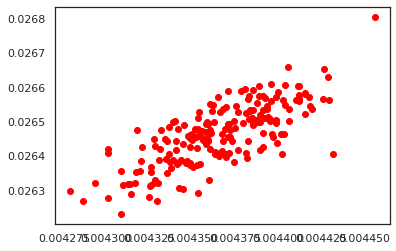

In [ ]:
fig = plt.figure()
ax = plt.subplot()
ax.scatter(w_x, w_y, c='red')
#ax.scatter(z_x, z_y, c='green')  # 改变颜色
plt.savefig("z.png")

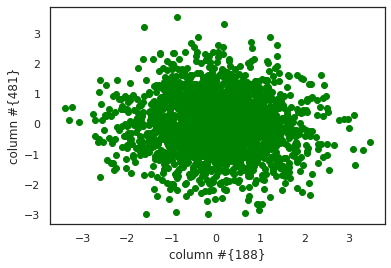

In [ ]:
a1,a2 = w[:,188],w[:,481]
b1,b2 = z[:,188],z[:,481]
fig = plt.figure()
ax = plt.subplot()
#ax.scatter(a1, a2, c='red')
ax.scatter(b1, b2, c='green')  # 改变颜色
plt.xlabel('column #{188}')
plt.ylabel('column #{481}')
plt.show()